In [1]:
!pip install tensorflow_text
!pip install https://github.com/PyThaiNLP/pythainlp/archive/dev.zip
!pip install pythainlp
!pip install fastai
!pip install emoji
!ls

     |████████████████████████████████| 3.4MB 8.4MB/s 
     / 12.7MB 133kB/s
     |████████████████████████████████| 747kB 7.5MB/s 
  Created wheel for pythainlp: filename=pythainlp-2.3.1-cp37-none-any.whl size=11006836 sha256=1ec0970df9a0637d9b7b8662509de159bfcdcd926e5c253af91d2a441fa432c8
  Stored in directory: /tmp/pip-ephem-wheel-cache-hm6etgfp/wheels/79/4e/1e/26f3198c6712ecfbee92928ed1dde923a078da3d222401cc78
Successfully built pythainlp
     |████████████████████████████████| 133kB 7.9MB/s 
sample_data


In [2]:
!pip install plotnine

In [3]:
!pip install iterative-stratification

In [4]:
!pip install sklearn_crfsuite

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd
import numpy as np
from pythainlp import word_tokenize
from ast import literal_eval
from tqdm import tqdm_notebook
from collections import Counter
import re

#viz
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns

import fastai
from fastai.text import *
from fastai.callbacks import CSVLogger

In [7]:
benchmark_labels = ['การเมือง','ต่างประเทศ','เศรษฐกิจ','การศึกษา']

In [8]:
def replace_newline(t):
    return re.sub('[\n]{1,}', ' ', t)

ft_data = 'ft_data/'

In [9]:
df = pd.read_csv('/content/drive/MyDrive/prachathai-67k.csv',index_col=['labels'])
print(df.shape)

(67889, 4)


In [10]:
df.head()

,url,date,title,body_text
labels,,,,
"['ข่าว', 'สิ่งแวดล้อม']",https://prachatai.com/print/42,2004-08-24 14:31,"นักวิจัยหนุน ""แม้ว"" เปิด ""จีเอ็มโอ""",ประชาไท --- 23 ส.ค.2547 นักวิจัยฯ ชี้นโยบายจี...
"['ข่าว', 'สิ่งแวดล้อม']",https://prachatai.com/print/41,2004-08-24 14:22,ภาคประชาชนต้านเปิดเสรีจีเอ็มโอ,ประชาไท- 23 ส.ค.2547 นักวิชาการ ภาคประชาชน จ...
"['ข่าว', 'สิ่งแวดล้อม']",https://prachatai.com/print/43,2004-08-24 15:17,จุฬาฯ ห่วงจีเอ็มโอลามข้าวไทย,นโยบายที่อนุญาตให้ปลูกร่วมกับพืชอื่นได้นั้นถื...
"['ข่าว', 'การเมือง', 'คณะเศรษฐศาสตร์ มหาวิทยาลัยธรรมศาสตร์', 'ชนชั้นกลาง', 'ซีอีโอ', 'ทักษิณ ชินวัตร', 'ทักษิโนมิกส์', 'มหาวิทยาลัยธรรมศาสตร์', 'ระบอบทักษิณ', 'รังสรรค์ ธนะพรพันธุ์', 'สุวินัย ภรณวลัย', 'เกษียร เตชะพีระ', 'เสวนา']",https://prachatai.com/print/45,2004-08-24 15:58,ฟองสบู่การเมืองแตก ทักษิณหมดกึ๋น ชนชั้นกลางหมด...,ประชาไท -- 23 ส.ค. 47 ขาประจำทักษิณ ฟันธง ฟอง...
"['ข่าว', 'สิ่งแวดล้อม']",https://prachatai.com/print/47,2004-08-24 16:10,กอต.เสนอเลิกถนนคลองลาน-อุ้มผาง,ประชาไท-23 ส.ค.47 คณะกรรมการอนุรักษ์ ผืนป่าตะ...


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67889 entries, ['ข่าว', 'สิ่งแวดล้อม'] to ['ข่าว', 'สิทธิมนุษยชน', 'ต่างประเทศ', 'อูยกูร์', 'เตอร์กิสถานตะวันออก', 'สภาอุยกูร์โลก', 'ค่ายกักกัน', 'วันประกาศเอกราช', 'จีน', 'ศาสนา', 'อิสลาม', 'ค่ายกักกันปลูกฝังความเชื่อใหม่']
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   url        67889 non-null  object
 1   date       67889 non-null  object
 2   title      67889 non-null  object
 3   body_text  67889 non-null  object
dtypes: object(4)
memory usage: 2.6+ MB


In [12]:
idx = pd.IndexSlice
idx

In [13]:
df.index.get_level_values(0).str.contains('การเมือง')

array([False, False, False,  True, ...,  True,  True,  True, False])

In [14]:
df_politics = df.loc[idx[df.index.get_level_values(0).str.contains('การเมือง')],:]

In [15]:
politics = df_politics[:400]

In [16]:
df_economics = df.loc[idx[df.index.get_level_values(0).str.contains('เศรษฐกิจ')],:]

In [17]:
economics = df_economics[:400]

In [18]:
df.international = df.loc[idx[df.index.get_level_values(0).str.contains('ต่างประเทศ')],:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [19]:
international = df.international[:400]

In [20]:
df.education = df.loc[idx[df.index.get_level_values(0).str.contains('การศึกษา')],:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [21]:
education = df.education[:400]

In [22]:
df_merge = pd.concat([politics,economics,international,education],ignore_index=False)

In [23]:
df_clean = df_merge.drop_duplicates()

In [24]:
df_clean = df_clean.reset_index(drop=False)

In [25]:
data = df_clean[['url','date','title','body_text','labels']]
data

,url,date,title,body_text,labels
0,https://prachatai.com/print/45,2004-08-24 15:58,ฟองสบู่การเมืองแตก ทักษิณหมดกึ๋น ชนชั้นกลางหมด...,ประชาไท -- 23 ส.ค. 47 ขาประจำทักษิณ ฟันธง ฟอง...,"['ข่าว', 'การเมือง', 'คณะเศรษฐศาสตร์ มหาวิทยาล..."
1,https://prachatai.com/print/46,2004-08-24 16:02,ชนชั้นกลางในความหมายของ เกษียร เตชะพีระ,รศ. เกษียร เตชะพีระ กล่าวอธิบายความหมายของชนช...,"['ข่าว', 'การเมือง', 'ชนชั้นกลาง', 'ทักษิณ ชิน..."
2,https://prachatai.com/print/87,2004-08-26 17:46,ทักษิโณมิกส์ ในสายตารังสรรค์ ธนะพรพันธุ์,ระบอบการเมืองการปกครองภายใต้ทักษิโณมิกส์เป็นร...,"['บทความ', 'การเมือง', 'เศรษฐกิจ', 'ขีดเส้นใต้..."
3,https://prachatai.com/print/4903,2005-07-06 16:37,"ครม.เรียกเงินคืนสำนักงบฯ 50,000 ล้าน",ประชาไท-5 กค. 48 คณะรัฐมนตรีเรียกงบประมาณคืนสำ...,"['ข่าว', 'การเมือง']"
4,https://prachatai.com/print/4904,2005-07-14 14:26,"""หมอแว""หยุดกิจกรรมประชาสังคมลุยหาเสียงส.ว.",[1]นายแพทย์แวมาหะดี แวดาโอ๊ะ อดีตจำเลยคดีเจไอ...,"['ข่าว', 'การเมือง']"
...,...,...,...,...,...
1539,https://prachatai.com/print/38437,2011-12-22 02:32,60 ปี ธเนศวร์ เจริญเมือง: ล้านนายูโทเปีย กับ เ...,"""ชาวแม่ขะ จานฟังตางนี้หื้อดี เปิ้นปิ๊กมาแล้ว ...","['บทความ', 'วัฒนธรรม', 'การศึกษา', 'สังคม', '6..."
1540,https://prachatai.com/print/38489,2011-12-25 23:33,นิติราษฎร์ เดินหน้า ลบล้างผลพวงรัฐประหาร แก้ไข...,นักวิชาการกลุ่มนิติราษฎร์ ประกาศกิจกรรมทางวิชา...,"['ข่าว', 'การเมือง', 'สิทธิมนุษยชน', 'การศึกษา..."
1541,https://prachatai.com/print/38558,2012-01-01 23:28,[คลิป] ธงชัย วินิจจะกูล: เมื่อความจริง (นิยาย)...,วิดีโอการอภิปรายของธงชัย วินิจจะกูล เกี่ยวกับห...,"['ข่าว', 'วัฒนธรรม', 'การศึกษา', 'สังคม', 'ขีด..."
1542,https://prachatai.com/print/38623,2012-01-05 18:24,"เสียงจากอดีตนักศึกษา: ถึง...เธอ, ผู้นำเชียร์งา...",โหวกเหวกส่งเสียงดัง ด้วยมุ่งหวังยังจุดหมาย ซัก...,"['บทความ', 'การศึกษา', 'กวีประชาไท', 'จุฬาลงกร..."


### Train-validation-test Split

In [26]:

all_df = data[['body_text', 'labels']].copy()
all_df.head()

#use only benchmark labels
for lab in benchmark_labels:
    all_df[lab] = all_df.labels.map(lambda x: 1 if lab in x else 0)
all_df.drop('labels',axis=1,inplace=True)

In [27]:
all_df.head()

,body_text,การเมือง,ต่างประเทศ,เศรษฐกิจ,การศึกษา
0,ประชาไท -- 23 ส.ค. 47 ขาประจำทักษิณ ฟันธง ฟอง...,1,0,0,0
1,รศ. เกษียร เตชะพีระ กล่าวอธิบายความหมายของชนช...,1,0,0,0
2,ระบอบการเมืองการปกครองภายใต้ทักษิโณมิกส์เป็นร...,1,0,1,0
3,ประชาไท-5 กค. 48 คณะรัฐมนตรีเรียกงบประมาณคืนสำ...,1,0,0,0
4,[1]นายแพทย์แวมาหะดี แวดาโอ๊ะ อดีตจำเลยคดีเจไอ...,1,0,0,0


In [28]:
#randomly create test set
idx = np.arange(all_df.shape[0])
np.random.seed(1412)
np.random.shuffle(idx)
train_valid_idx, test_idx = idx[:int(all_df.shape[0] * 0.8)], idx[int(all_df.shape[0] * 0.8):]
print(len(train_valid_idx),len(test_idx))

1235 309


In [29]:
#save test_df
test_df = all_df.iloc[test_idx,:]
print(test_df.shape)
test_df.to_csv('/content/drive/MyDrive/ject_final_petch/test_df.csv',index=False)

(309, 5)


In [30]:
#stratified shuffle split for validation set
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

train_valid_df = all_df.iloc[train_valid_idx,:]
ohe_df = train_valid_df.iloc[:,1:]
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.125, random_state=1412)
train_idx, valid_idx = next(msss.split(ohe_df,ohe_df))
print(len(train_idx),len(valid_idx))

1082 153


In [31]:
#save train and valid_df
train_df = train_valid_df.iloc[train_idx,:]
print(train_df.shape)
train_df.to_csv('/content/drive/MyDrive/ject_final_petch/train_df.csv',index=False)

valid_df = all_df.iloc[valid_idx,:]
print(valid_df.shape)
valid_df.to_csv('/content/drive/MyDrive/ject_final_petch/valid_df.csv',index=False)

(1082, 5)
(153, 5)


In [32]:
#save train_valid_idx, test_idx for reproducibility
import pickle
pickle.dump(train_valid_idx,open('/content/drive/MyDrive/ject_final_petch/train_valid_idx.pkl','wb'))
pickle.dump(test_idx,open('/content/drive/MyDrive/ject_final_petch/test_idx.pkl','wb'))

In [33]:
#test set prevalence
test_df.iloc[:,1:].mean(0)

การเมือง      0.469256
ต่างประเทศ    0.333333
เศรษฐกิจ      0.278317
การศึกษา      0.242718
dtype: float64

In [34]:
import pandas as pd
import numpy as np
from ast import literal_eval
from tqdm import tqdm_notebook
from collections import Counter
import re

#viz
import matplotlib.pyplot as plt
import seaborn as sns

from fastai.text import *
from fastai.callbacks import CSVLogger, SaveModelCallback

from pythainlp.ulmfit import *


model_path = '/content/drive/MyDrive/ject_final_petch/prachathai_data/'

train_df = pd.read_csv('/content/drive/MyDrive/ject_final_petch/train_df.csv')
valid_df = pd.read_csv('/content/drive/MyDrive/ject_final_petch/valid_df.csv')
test_df = pd.read_csv('/content/drive/MyDrive/ject_final_petch/test_df.csv')
all_df = pd.concat([train_df,valid_df,test_df],0).reset_index(drop=True)

Corpus: wiki_lm_lstm
- Downloading: wiki_lm_lstm 0.32


100%|██████████| 1050919089/1050919089 [00:15<00:00, 68486640.35it/s]


Corpus: wiki_itos_lstm
- Downloading: wiki_itos_lstm 0.32


100%|██████████| 1530484/1530484 [00:00<00:00, 19781807.31it/s]


#### Finetune Language Model

In [35]:
#get vocab
thwiki_itos = pickle.load(open(THWIKI_LSTM['itos_fname'], 'rb'))
thwiki_vocab = fastai.text.transform.Vocab(thwiki_itos)

tt = Tokenizer(tok_func = ThaiTokenizer, lang = 'th', pre_rules = pre_rules_th, post_rules=post_rules_th)
processor = [TokenizeProcessor(tokenizer=tt, chunksize=10000, mark_fields=False),
            NumericalizeProcessor(vocab=None, max_vocab=60000, min_freq=3)]

In [36]:
data_lm = (TextList.from_df(all_df, model_path, cols=['body_text'], processor=processor)
    .split_by_rand_pct(valid_pct = 0.01, seed = 1412)
    .label_for_lm()
    .databunch(bs=64))

data_lm.sanity_check()

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [39]:
data_lm

TextLMDataBunch;

Train: LabelList (1529 items)
x: LMTextList
xxbos   
       
   
   
   
       
   
       
   
       
   
       
   
       
   
   6     สิงหาคม   2488   ระเบิดปรมาณู ลูก แรก ถูก ทิ้ง ลง ไป ถล่ม เมือง ฮิ โร ชิ มา ของ ประเทศญี่ปุ่น   นับ เป็นครั้งแรก ที่ มี การ ใช้ ระเบิดปรมาณู ใน สงคราม   และ นับ เป็นครั้งแรก ที่ มวล มนุษยชาติ ได้ สัมผัส กับ อานุภาพ แห่ง ระเบิดปรมาณู   อีก   3   วัน   ต่อมา   9   สิงหาคม   2488   ระเบิด ลูก ที่สอง ก็ ตามมา อีก ที่ เมือง นา งา ซา กิ   ผล ก็ คือ   ต่อมา วันที่   14   สิงหาคม ญี่ปุ่น ประกาศ ยอมแพ้   อย่าง ไม่มีเงื่อนไข ใดๆ   เป็น การยุติ มหา สงคราม เอเชีย บูรพา   หรือ สงครามโลก ครั้ง ที่   2   
   
       
   
   
   
   ผล จาก ระเบิดปรมาณู ครั้งนั้น   เชื่อ ว่า ทำให้ ชาวเมือง ฮิ โร ชิ มา ร้อยละ   40   ต้อง เสียชีวิต   และ เช่น กันที่ เมือง นา งา ซา กิ ที่ ได้ เสียชีวิต ของ พลเมือง ไป ประมาณ ร้อยละ   31   โดย มี ผู้ ที่ รอดชีวิต ใน ฮิ โร ชิ มา ประมาณ   210,000   คน   และ   166,000   คน ที่นา งา ซา กิ ที่ รอดชีวิต มาจาก เหตุการณ์ นั้

In [ ]:
data_lm.save('/content/drive/MyDrive/ject_final_petch/prachathai_lm.pkl')

In [ ]:
data_lm = load_data(model_path,'/content/drive/MyDrive/ject_final_petch/prachathai_lm.pkl')
data_lm.sanity_check()
print(len(data_lm.train_ds), len(data_lm.valid_ds))

1529 15


In [ ]:
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False, tie_weights=True, out_bias=True,
             output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
trn_args = dict(drop_mult=0.9, clip=0.12, alpha=2, beta=1)

learn = language_model_learner(data_lm, AWD_LSTM, config=config, pretrained=False, **trn_args)


In [ ]:
#load pretrained models
learn.load_pretrained(**THWIKI_LSTM)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (1529 items)
x: LMTextList
xxbos   
       
   
   
   
       
   
       
   
       
   
       
   
       
   
   6     สิงหาคม   2488   ระเบิดปรมาณู ลูก แรก ถูก ทิ้ง ลง ไป ถล่ม เมือง ฮิ โร ชิ มา ของ ประเทศญี่ปุ่น   นับ เป็นครั้งแรก ที่ มี การ ใช้ ระเบิดปรมาณู ใน สงคราม   และ นับ เป็นครั้งแรก ที่ มวล มนุษยชาติ ได้ สัมผัส กับ อานุภาพ แห่ง ระเบิดปรมาณู   อีก   3   วัน   ต่อมา   9   สิงหาคม   2488   ระเบิด ลูก ที่สอง ก็ ตามมา อีก ที่ เมือง นา งา ซา กิ   ผล ก็ คือ   ต่อมา วันที่   14   สิงหาคม ญี่ปุ่น ประกาศ ยอมแพ้   อย่าง ไม่มีเงื่อนไข ใดๆ   เป็น การยุติ มหา สงคราม เอเชีย บูรพา   หรือ สงครามโลก ครั้ง ที่   2   
   
       
   
   
   
   ผล จาก ระเบิดปรมาณู ครั้งนั้น   เชื่อ ว่า ทำให้ ชาวเมือง ฮิ โร ชิ มา ร้อยละ   40   ต้อง เสียชีวิต   และ เช่น กันที่ เมือง นา งา ซา กิ ที่ ได้ เสียชีวิต ของ พลเมือง ไป ประมาณ ร้อยละ   31   โดย มี ผู้ ที่ รอดชีวิต ใน ฮิ โร ชิ มา ประมาณ   210,000   คน   และ   166,000   คน ที่นา งา ซา กิ ที่ รอดชีวิ

In [ ]:
#train frozen
print('training frozen')
learn.freeze_to(-1)
learn.fit_one_cycle(1, 1e-3, moms=(0.8, 0.7))

#train unfrozen
print('training unfrozen')
learn.unfreeze()
learn.fit_one_cycle(10, 1e-4, moms=(0.8, 0.7),
                   callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name='best_lm')])

learn.save('/content/drive/MyDrive/ject_final_petch/prachathai_lm')
learn.save_encoder('/content/drive/MyDrive/ject_final_petch/prachathai_enc')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#learn.lr_find()
#learn.recorder.plot()

In [ ]:
import pandas as pd 
import numpy as np
from pythainlp import word_tokenize
from ast import literal_eval
from tqdm import tqdm_notebook
from collections import Counter
import re
import emoji
import string
from fastai.text import *
from fastai.callbacks import CSVLogger, SaveModelCallback
from pythainlp.ulmfit import *

# #when training with augmented set
train_df = pd.read_csv('/content/drive/MyDrive/ject_final_petch/train_df.csv')
valid_df = pd.read_csv('/content/drive/MyDrive/ject_final_petch/valid_df.csv')

#test set
test_df = pd.read_csv('/content/drive/MyDrive/ject_final_petch/test_df.csv')

model_path = '/content/drive/MyDrive/ject_final_petch/prachathai_data/'

#lm data
data_lm = load_data(model_path,'/content/drive/MyDrive/ject_final_petch/prachathai_lm.pkl')
data_lm.sanity_check()

#classification data
tt = Tokenizer(tok_func = ThaiTokenizer, lang = 'th', pre_rules = pre_rules_th, post_rules=post_rules_th)
processor = [TokenizeProcessor(tokenizer=tt, chunksize=10000, mark_fields=False),
            NumericalizeProcessor(vocab=data_lm.vocab, max_vocab=60000, min_freq=3)]
data_cls = (ItemLists(model_path,train=TextList.from_df(train_df, model_path, cols=['body_text'], processor=processor),
                     valid=TextList.from_df(valid_df, model_path, cols=['body_text'], processor=processor))
    .label_from_df(list(train_df.columns[1:]))
    .add_test(TextList.from_df(test_df, model_path, cols=['body_text'], processor=processor))
    .databunch(bs=50)
    )
data_cls.sanity_check()
data_cls.save('/content/drive/MyDrive/ject_final_petch/prachathai_cls.pkl')

#just load
data_cls = load_data(model_path,'/content/drive/MyDrive/ject_final_petch/prachathai_cls.pkl')
data_cls.sanity_check()
print(len(data_cls.vocab.itos))

#model
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False,
             output_p=0.4, hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
trn_args = dict(bptt=70, drop_mult=0.5, alpha=2, beta=1, max_len=500)

learn = text_classifier_learner(data_cls, AWD_LSTM, config=config, pretrained=False, **trn_args)
#load pretrained finetuned model
learn.load_encoder('/content/drive/MyDrive/ject_final_petch/prachathai_enc')

#train unfrozen
learn.freeze_to(-1)
learn.fit_one_cycle(1, 2e-2, moms=(0.8, 0.7))
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2 / (2.6 ** 4), 1e-2), moms=(0.8, 0.7))
learn.freeze_to(-3)
learn.fit_one_cycle(10, slice(5e-3 / (2.6 ** 4), 5e-3), moms=(0.8, 0.7), 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='val_loss', name='prachathai_cls')])
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3 / (2.6 ** 4), 1e-3), moms=(0.8, 0.7))

#save test results
probs, y_true = learn.get_preds(ds_type = DatasetType.Test, ordered=True)
probs = probs.numpy()
pickle.dump(probs, open(f'{model_path}probs.pkl','wb'))

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

18944


epoch,train_loss,valid_loss,time
0,0.484933,0.489061,01:08


epoch,train_loss,valid_loss,time
0,0.387837,0.367163,01:12


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


epoch,train_loss,valid_loss,time
0,0.309877,0.304996,01:15
1,0.291708,0.266833,01:16
2,0.273136,0.249608,01:16
3,0.249239,0.197415,01:18
4,0.218665,0.190180,01:17
5,0.190002,0.181318,01:23
6,0.158685,0.165283,01:23
7,0.129751,0.159511,01:17
8,0.109392,0.160999,01:22
9,0.093687,0.162301,01:26


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/fastai/callbacks/tracker.py:50: UserWarning: <class 'fastai.callbacks.tracker.SaveModelCallback'> conditioned on metric `val_loss` which is not available. Available metrics are: train_loss, valid_loss
  warn(f'{self.__class__} conditioned on metric `{self.monitor}` which is not available. Available met

epoch,train_loss,valid_loss,time
0,0.054584,0.164736,01:34
1,0.053886,0.168696,01:28
2,0.052939,0.167600,01:37
3,0.050261,0.174324,01:33
4,0.048570,0.170577,01:37
5,0.046161,0.179526,01:31
6,0.043832,0.178663,01:28
7,0.040921,0.180530,01:29
8,0.038932,0.178906,01:28
9,0.037558,0.178189,01:31


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

epoch,train_loss,valid_loss,time
0,0.031227,#na#,01:16
1,0.032739,#na#,01:11
2,0.031812,#na#,01:11
3,0.085164,#na#,01:13


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


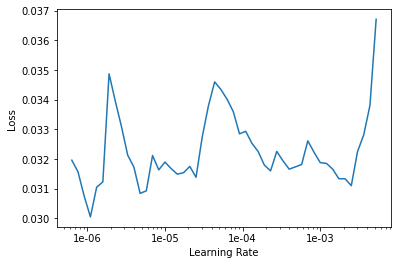

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
probs = pickle.load(open(f'{model_path}probs.pkl','rb'))
preds = (probs > 0.5).astype(int)
y_true = np.array(test_df.iloc[:,1:])
probs.shape, y_true.shape

((309, 4), (309, 4))

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score
#macro metrics
for i in range(4):
    print(
        (preds[:,i]==y_true[:,i]).mean(),
        f1_score(preds[:,i],y_true[:,i]),
        precision_score(preds[:,i],y_true[:,i]),
        recall_score(preds[:,i],y_true[:,i])
         )

0.7993527508090615 0.7832167832167832 0.7724137931034483 0.7943262411347518
0.9061488673139159 0.8557213930348259 0.8349514563106796 0.8775510204081632
0.8802588996763754 0.7932960893854749 0.8255813953488372 0.7634408602150538
0.9255663430420712 0.8391608391608392 0.8 0.8823529411764706


In [ ]:
#benchmark_labels = ['การเมือง','ต่างประเทศ','เศรษฐกิจ','การศึกษา']

In [ ]:
learn.save('/content/drive/MyDrive/ject_final_petch/01a-learner_text_classifier-2')

In [ ]:
import numpy as np
learn.load('/content/drive/MyDrive/ject_final_petch/01a-learner_text_classifier-2');

In [ ]:
learn.predict("ระบอบการเมืองการปกครองภายใต้ทักษิณ")

(MultiCategory tensor([1., 0., 0., 0.]),
 tensor([1., 0., 0., 0.]),
 tensor([0.9714, 0.4378, 0.0062, 0.2371]))

In [ ]:
learn.predict("ประชาไท-5 กค. 48 คณะรัฐมนตรีเรียกงบประมาณคืน")

(MultiCategory tensor([1., 1., 0., 0.]),
 tensor([1., 1., 0., 0.]),
 tensor([0.9916, 0.8557, 0.0174, 0.3920]))

In [ ]:
learn.predict("เครือข่ายวิถีชนคนพอเพียง ได้มีการจัดค่ายเยาวชน")

(MultiCategory tensor([1., 0., 1., 0.]),
 tensor([1., 0., 1., 0.]),
 tensor([0.6294, 0.0025, 0.9965, 0.1445]))

In [ ]:
learn.predict("อันดับการศึกษาภายในประเทศไทยผลเฉลี่ยแย่ที่สุดในรอบปี")

(MultiCategory tensor([0., 0., 0., 1.]),
 tensor([0., 0., 0., 1.]),
 tensor([0.0012, 0.0511, 0.0022, 1.0000]))

In [ ]:
learn.predict("หุ้นของประเทศไทยลดลงอย่างมาก")

(MultiCategory tensor([1., 0., 1., 0.]),
 tensor([1., 0., 1., 0.]),
 tensor([0.9578, 0.0357, 0.9914, 0.0023]))

##### train_cls.py.

In [ ]:
# #when training with augmented set
#train_df = pd.read_csv('/content/drive/MyDrive/ject_petch/train_df.csv')
#valid_df = pd.read_csv('/content/drive/MyDrive/ject_petch/valid_df.csv')

#test set
#test_df = pd.read_csv('/content/drive/MyDrive/ject_petch/test_df.csv')

In [ ]:
#model_path = '/content/drive/MyDrive/ject_petch/prachathai_data/'

#lm data
#data_lm = load_data(model_path,'/content/sample_data/prachathai_lm_1.pkl')
#data_lm.sanity_check()

In [ ]:
#classification data
#tt = Tokenizer(tok_func = ThaiTokenizer, lang = 'th', pre_rules = pre_rules_th, post_rules=post_rules_th)
#processor = [TokenizeProcessor(tokenizer=tt, chunksize=10000, mark_fields=False),
#            NumericalizeProcessor(vocab=data_lm.vocab, max_vocab=60000, min_freq=3)]
#data_cls = (ItemLists(model_path,train=TextList.from_df(train_df, model_path, cols=['body_text'], processor=processor),
#                     valid=TextList.from_df(valid_df, model_path, cols=['body_text'], processor=processor))
#    .label_from_df(list(train_df.columns[1:]))
#    .add_test(TextList.from_df(test_df, model_path, cols=['body_text'], processor=processor))
#    .databunch(bs=50)
#    )

In [ ]:
#data_cls.sanity_check()
#data_cls.save('/content/drive/MyDrive/ject_petch/prachathai_cls.pkl')

In [ ]:
#just load
#data_cls = load_data(model_path,'/content/prachathai_data/prachathai_cls_1.pkl')
#data_cls.sanity_check()
#print(len(data_cls.vocab.itos))

In [ ]:
#model
#config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False,
#             output_p=0.4, hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
#trn_args = dict(bptt=70, drop_mult=0.5, alpha=2, beta=1, max_len=500)


In [ ]:
#learn = text_classifier_learner(data_cls, AWD_LSTM, config=config, pretrained=False, **trn_args)

In [ ]:
#learn.opt_func = partial(optim.Adam, betas=(0.7, 0.99))

In [ ]:
#learn.unfreeze()

In [ ]:
#learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
#learn.recorder.plot()

In [ ]:
learn.save('04a-learner_text_classifier-2')

In [ ]:
learn.load('04a-learner_text_classifier-2');

In [ ]:
learn.predict("ระบอบการเมืองการปกครองภายใต้ทักษิณ")

(MultiCategory tensor([1., 0., 0., 0.]),
 tensor([1., 0., 0., 0.]),
 tensor([0.9714, 0.4378, 0.0062, 0.2371]))

In [ ]:
learn.predict("ประชาไท-5 กค. 48 คณะรัฐมนตรีเรียกงบประมาณคืน")

(MultiCategory tensor([1., 1., 0., 0.]),
 tensor([1., 1., 0., 0.]),
 tensor([0.9916, 0.8557, 0.0174, 0.3920]))

In [ ]:
learn.predict("เครือข่ายวิถีชนคนพอเพียง ได้มีการจัดค่ายเยาวชน")

(MultiCategory tensor([1., 0., 1., 0.]),
 tensor([1., 0., 1., 0.]),
 tensor([0.6294, 0.0025, 0.9965, 0.1445]))

In [ ]:
learn.predict("อันดับการศึกษาภายในประเทศไทย")

(MultiCategory tensor([0., 0., 0., 1.]),
 tensor([0., 0., 0., 1.]),
 tensor([3.4038e-04, 1.9439e-02, 1.2730e-03, 1.0000e+00]))

In [ ]:
learn.predict("หุ้นของประเทศไทยลดลงอย่างมาก")

(MultiCategory tensor([1., 0., 1., 0.]),
 tensor([1., 0., 1., 0.]),
 tensor([0.9578, 0.0357, 0.9914, 0.0023]))

In [ ]:
benchmark_labels = ['การเมือง','ต่างประเทศ','เศรษฐกิจ','การศึกษา']